In [1]:
'''
    Generate polygons from SOM centroids and perform tessleation: 
        I: validate polygons from tesselation against shapefile projection
        II: try doubling the grid dimensions, preserving the ratio of grid
        III: export the polygons to a shapefile and validate io preservation of polygons
        IV: for different initializations of SOM (grid, radius, epochs etc)
            - you need to compare the similarity of the polygons that are built
            - this will provide an immediate sanity check on the stability of the model 
'''

# -- 
# dependancies 

import pandas as pd
import numpy as np
import json 
import geojson
import matplotlib.pyplot as plt 
from pprint import pprint 
from dateutil import parser

import pytess
from shapely.geometry import shape, Point
from descartes import PolygonPatch
from shapely import geometry
from shapely.geometry.polygon import LinearRing, Polygon
from shapely.geometry import Polygon, mapping
from scipy.spatial import Voronoi, voronoi_plot_2d

from neupy import algorithms, environment
from neupy import utils


In [2]:
with open("../data/beijing.geojson") as json_file:
    json_data = geojson.load(json_file)

df_weibo = pd.read_csv('../data/inLabelRegionPoints.csv')

In [3]:
GRID_HEIGHT = 18
GRID_WIDTH = 22

wbArray = np.array(df_weibo[['lon', 'lat']])
sofm = algorithms.SOFM(
    n_inputs=2,
    features_grid=(GRID_HEIGHT, GRID_WIDTH),
    verbose=True,
    shuffle_data=True,
    distance='euclid',
    # distance='haversine',
    learning_radius=2,
    reduce_radius_after=20,
    std=2,
    reduce_std_after=50,
    step=0.3,
    reduce_step_after=50,
)


# -- 
# train model and build dataframe of centroids (40 epochs)

n_epochs = 100 # 20; 40
sofm.train(wbArray, epochs=n_epochs)
preds = sofm.predict(wbArray)
dfp = pd.DataFrame(preds)
dfp['label'] = dfp.idxmax(axis=1)
dfp.reset_index(inplace=True)
npd34 = sofm.weight
npd34Lats, npd34Lons = npd34[1], npd34[0]

coords = [] 
for i in range(len(npd34Lats)): 
    lat, lon = npd34Lats[i], npd34Lons[i]
    out = {
        'lat' : lat, 
        'lon' : lon
    }
    coords.append(out)


Main information

[ALGORITHM] SOFM

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = True
[OPTION] step = 0.3
[OPTION] train_end_signal = None
[OPTION] n_inputs = 2
[OPTION] distance = euclid
[OPTION] features_grid = [18, 22]
[OPTION] grid_type = rect
[OPTION] learning_radius = 2
[OPTION] n_outputs = None
[OPTION] reduce_radius_after = 20
[OPTION] reduce_std_after = 50
[OPTION] reduce_step_after = 50
[OPTION] std = 2
[OPTION] weight = Normal(mean=0, std=0.01)


Start training

[TRAINING DATA] shapes: (164645, 2)
[TRAINING] Total epochs: 100

---------------------------------------------------------
|    Epoch    |  Train err  |  Valid err  |    Time     |
---------------------------------------------------------
|           1 |    0.073092 |           - |      44 sec |
|           2 |    0.016493 |           - |      44 sec |
|           3 |    0.016496 |           - |      43 sec |
|           4 |    0.016393 |           - |    

In [4]:
dfcnt_18_22 = pd.DataFrame(coords)
dfcnt_18_22.to_csv('../data/centroids-18-22-som-100e.csv', index=False)
dfcnt_18_22.head()

,lat,lon
0,40.122902,116.135897
1,40.189036,116.149351
2,40.212299,116.244199
3,40.204982,116.306079
4,40.165930,116.317233


In [6]:
# get corners of ROI to specify plotting window
maxLon, minLon = np.max(df_weibo['lon']), np.min(df_weibo['lon'])
maxLat, minLat = np.max(df_weibo['lat']), np.min(df_weibo['lat'])
corners = [(minLon, maxLat), (maxLon, maxLat), (maxLon, minLat), (minLon, minLat)]
dfCorners = pd.DataFrame(corners)
dfCorners.columns = ['lon', 'lat']


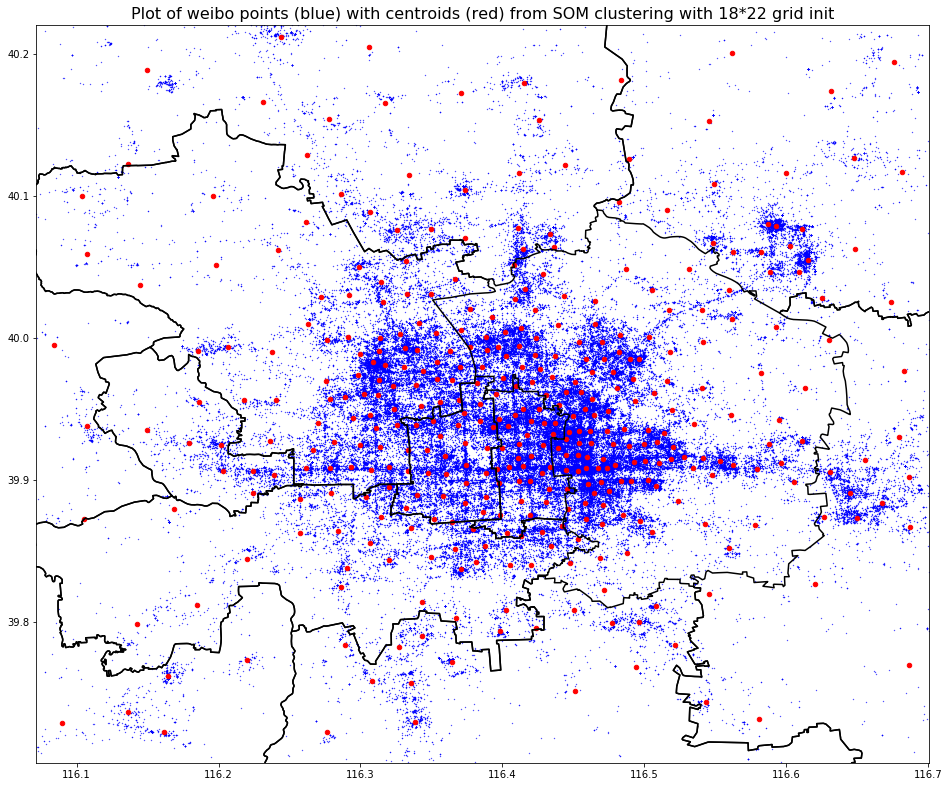

In [11]:
# plot beijing region of interest
fig = plt.figure(figsize=(16,16))
feats = json_data['features']
for i in range(0, len(feats)): 
    try: 
        test = feats[i]
        poly = test['geometry']
        coords = poly['coordinates']
        x = [i for i,j in coords[0]]
        y = [j for i,j in coords[0]]
        ax = fig.gca() 
        ax.plot(x, y, color='black')
        ax.axis('scaled')
    except: 
        continue


# plot scatter of weibo points 
ax.scatter(df_weibo['lon'], df_weibo['lat'], color='blue', s=0.1)

# plot centroids from SOM clustering
ax.scatter(dfcnt_18_22['lon'], dfcnt_18_22['lat'], color='red', s=20)

# limit axes to ROI 
ax.set_xlim(minLon, maxLon)
ax.set_ylim(minLat, maxLat)

# reveal plot
plt.title('Plot of weibo points (blue) with centroids (red) from SOM clustering with 18*22 grid init', fontsize=16)
plt.show()  